In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import argparse
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model, save_model, model_from_json, clone_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, Input, GlobalAveragePooling2D, AveragePooling2D, ZeroPadding2D, Add, Lambda, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import categorical_crossentropy
from keras.utils import to_categorical
from keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2



In [2]:
Dataset_dir = r"E:\merged_waste_dataset"
# image resize
Image_size = (224,224)
batch_size = 64
seed = 42


In [3]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    Dataset_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=Image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    seed=seed
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    Dataset_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=Image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=seed
)

class_names = train_ds.class_names
print(class_names)


Found 110753 files belonging to 46 classes.
Using 88603 files for training.
Found 110753 files belonging to 46 classes.
Using 22150 files for validation.
['1. Polythene', '1. Sugarcane  husk', '10.Mask', '4. Glass', '5. Wire', '6. Glaves', '7. Empty medicine packet', 'Battery', 'Keyboard', 'Microwave', 'Miscellanous_trash', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Textile Trash', 'Washing Machine', 'background_ground', 'food_dishes', 'food_items', 'food_recyclable', 'fruits_and_vegetables', 'gauze', 'glove_pair_latex', 'glove_pair_nitrile', 'glove_pair_surgery', 'glove_single_latex', 'glove_single_nitrile', 'glove_single_surgery', 'leaves_flowers', 'medical_cap', 'medical_glasses', 'organic_waste', 'paper_cardboard', 'paper_waste', 'plastic_containers_bottles_etc', 'plastic_mixed', 'recyclable', 'recyclable_metal', 'shoe_cover_pair', 'shoe_cover_single', 'test_tube', 'urine_bag', 'vegetables_and_fruits']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


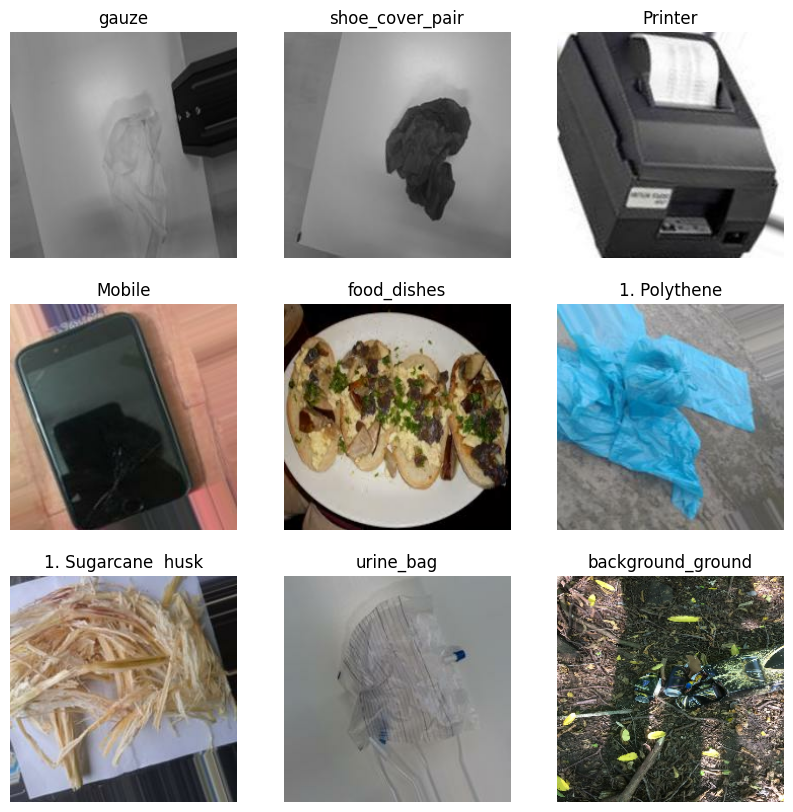

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    num_img = min(9, images.shape[0])  # Avoid crash if batch < 9

    for i in range(num_img):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")


In [6]:

import os, hashlib

DATASET = Dataset_dir   # <-- uses your existing variable

def file_hash(path):
    """Returns SHA-256 hash of a file."""
    with open(path, "rb") as f:
        return hashlib.sha256(f.read()).hexdigest()

def remove_duplicates(root):
    hashes = {}
    deleted = 0

    for folder, _, files in os.walk(root):
        for file in files:
            path = os.path.join(folder, file)

            try:
                h = file_hash(path)
                if h in hashes:
                    os.remove(path)     # duplicate found
                    deleted += 1
                else:
                    hashes[h] = path
            except:
                pass

    print(f"[INFO] Duplicate images removed: {deleted}")

remove_duplicates(DATASET)


[INFO] Duplicate images removed: 0


In [7]:
from PIL import Image
import os

def remove_low_res(root, min_size=(200, 200)):
    deleted = 0

    for folder, _, files in os.walk(root):
        for file in files:
            path = os.path.join(folder, file)
            try:
                # open image safely using context manager
                with Image.open(path) as img:
                    if img.width < min_size[0] or img.height < min_size[1]:
                        img.close()  # optional (context auto closes)
                        os.remove(path)
                        deleted += 1
            except:
                # corrupted / unreadable file → remove
                try:
                    os.remove(path)
                    deleted += 1
                except:
                    pass  # file locked by another app

    print(f"[INFO] Low-resolution/unreadable removed: {deleted}")


In [8]:
from collections import Counter

def class_report(root):
    counts = {}
    for cls in os.listdir(root):
        folder = os.path.join(root, cls)
        if os.path.isdir(folder):
            counts[cls] = len(os.listdir(folder))
    return counts

report = class_report(DATASET)
print("\n[INFO] Class Distribution:")
print(report)



[INFO] Class Distribution:
{'1. Polythene': 2156, '1. Sugarcane  husk': 2426, '10.Mask': 2422, '4. Glass': 2426, '5. Wire': 2203, '6. Glaves': 2209, '7. Empty medicine packet': 2298, 'background_ground': 2426, 'Battery': 2426, 'food_dishes': 2426, 'food_items': 2426, 'food_recyclable': 2426, 'fruits_and_vegetables': 2426, 'gauze': 2425, 'glove_pair_latex': 2426, 'glove_pair_nitrile': 2426, 'glove_pair_surgery': 2426, 'glove_single_latex': 2426, 'glove_single_nitrile': 2426, 'glove_single_surgery': 2426, 'Keyboard': 2426, 'leaves_flowers': 2426, 'medical_cap': 2426, 'medical_glasses': 2426, 'Microwave': 2426, 'Miscellanous_trash': 2426, 'Mobile': 2426, 'Mouse': 2426, 'organic_waste': 2426, 'paper_cardboard': 2426, 'paper_waste': 2426, 'PCB': 2426, 'plastic_containers_bottles_etc': 2426, 'plastic_mixed': 2426, 'Player': 2426, 'Printer': 2426, 'recyclable': 2426, 'recyclable_metal': 2426, 'shoe_cover_pair': 2426, 'shoe_cover_single': 2426, 'Television': 2426, 'test_tube': 2426, 'Textile 

data augmentation


In [9]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmenter = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    horizontal_flip=True,
)

def class_report(root):
    report = {}
    for cls in os.listdir(root):
        folder = os.path.join(root, cls)
        if os.path.isdir(folder):
            count = len([f for f in os.listdir(folder) if f.lower().endswith((".jpg",".jpeg",".png"))])
            report[cls] = count
    return report


def balance_dataset(root):
    print("[INFO] Scanning dataset...")
    class_counts = class_report(root)

    # If dataset is empty
    if len(class_counts) == 0:
        print("[ERROR] No classes found in dataset!")
        return

    max_count = max(class_counts.values())
    print(f"[INFO] Largest class has {max_count} images")

    for cls, count in class_counts.items():
        folder = os.path.join(root, cls)

        if count < max_count:
            to_add = max_count - count
            print(f"[INFO] Augmenting class '{cls}' → adding {to_add} images")

            files = [f for f in os.listdir(folder) if f.lower().endswith((".jpg",".jpeg",".png"))]

            # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
            # FIX: Skip empty folders
            # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
            if len(files) == 0:
                print(f"[WARNING] Skipping '{cls}' — folder has 0 images!")
                continue

            for i in range(to_add):
                img_path = os.path.join(folder, files[i % len(files)])
                img = Image.open(img_path).convert("RGB")
                img = img.resize((224, 224))
                arr = np.expand_dims(np.array(img), 0)

                aug_img = next(augmenter.flow(arr, batch_size=1))[0]
                out = Image.fromarray(aug_img.astype('uint8'))
                out.save(os.path.join(folder, f"aug_{i}.jpg"))

print("\n[INFO] Dataset balanced successfully.\n")



[INFO] Dataset balanced successfully.



In [10]:
class_report(DATASET)


{'1. Polythene': 2156,
 '1. Sugarcane  husk': 2426,
 '10.Mask': 2422,
 '4. Glass': 2426,
 '5. Wire': 2203,
 '6. Glaves': 2209,
 '7. Empty medicine packet': 2298,
 'background_ground': 2426,
 'Battery': 2426,
 'food_dishes': 2426,
 'food_items': 2426,
 'food_recyclable': 2426,
 'fruits_and_vegetables': 2426,
 'gauze': 2425,
 'glove_pair_latex': 2426,
 'glove_pair_nitrile': 2426,
 'glove_pair_surgery': 2426,
 'glove_single_latex': 2426,
 'glove_single_nitrile': 2426,
 'glove_single_surgery': 2426,
 'Keyboard': 2426,
 'leaves_flowers': 2426,
 'medical_cap': 2426,
 'medical_glasses': 2426,
 'Microwave': 2426,
 'Miscellanous_trash': 2426,
 'Mobile': 2426,
 'Mouse': 2426,
 'organic_waste': 2426,
 'paper_cardboard': 2426,
 'paper_waste': 2426,
 'PCB': 2426,
 'plastic_containers_bottles_etc': 2426,
 'plastic_mixed': 2426,
 'Player': 2426,
 'Printer': 2426,
 'recyclable': 2426,
 'recyclable_metal': 2426,
 'shoe_cover_pair': 2426,
 'shoe_cover_single': 2426,
 'Television': 2426,
 'test_tube': 24

In [11]:
from PIL import Image
import os

def validate_images(root):
    bad = 0
    for cls in os.listdir(root):
        folder = os.path.join(root, cls)
        for f in os.listdir(folder):
            path = os.path.join(folder, f)
            try:
                img = Image.open(path)
                img.verify()
            except:
                print("[BAD]", path)
                bad += 1
                os.remove(path)
    print(f"[INFO] Corrupt images removed: {bad}")

validate_images(DATASET)


[INFO] Corrupt images removed: 0


In [12]:
import cv2
import numpy as np

def image_shape_analysis(root):
    shapes = {}
    for cls in os.listdir(root):
        folder = os.path.join(root, cls)
        for f in os.listdir(folder):
            path = os.path.join(folder, f)
            img = cv2.imread(path)
            if img is not None:
                shapes[path] = img.shape
    return shapes

shapes = image_shape_analysis(DATASET)
print("Sample shapes:", list(shapes.values())[:10])


Sample shapes: [(1280, 960, 3), (3096, 4128, 3), (4128, 3096, 3), (4128, 3096, 3), (1600, 1200, 3), (1600, 1200, 3), (1600, 1200, 3), (1600, 1200, 3), (1600, 1200, 3), (1280, 960, 3)]


In [13]:
import cv2
import numpy as np

def quality_metrics(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    brightness = np.mean(img)
    contrast = img.std()
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()

    return brightness, contrast, laplacian_var


def compute_quality_report(root):
    metrics = {cls: [] for cls in os.listdir(root)}

    for cls in os.listdir(root):
        folder = os.path.join(root, cls)
        for f in os.listdir(folder):
            path = os.path.join(folder, f)
            b, c, l = quality_metrics(path)
            metrics[cls].append([b, c, l])

    return metrics

report = compute_quality_report(DATASET)
print("[INFO] Done computing quality report")


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 16588800 bytes in function 'cv::OutOfMemoryError'


In [ ]:
def dataset_verdict(class_counts, metrics):
    verdict = []

    # Balance check
    if len(set(class_counts.values())) == 1:
        verdict.append("✔ Dataset is balanced")
    else:
        verdict.append("❌ Dataset is NOT balanced")

    # Quality checks
    for cls, m in metrics.items():
        arr = np.array(m)
        brightness_mean = arr[:,0].mean()
        contrast_mean = arr[:,1].mean()
        blur_mean = arr[:,2].mean()

        verdict.append(f"\nClass: {cls}")
        verdict.append(f"  • Avg Brightness: {brightness_mean:.2f}")
        verdict.append(f"  • Avg Contrast: {contrast_mean:.2f}")
        verdict.append(f"  • Avg Sharpness(Laplacian): {blur_mean:.2f}")

        if blur_mean < 30:
            verdict.append("  → ⚠ Images are slightly blurry")
        else:
            verdict.append("  → ✔ Sharpness is good")

    return "\n".join(verdict)

print(dataset_verdict(class_report(DATASET), report))


❌ Dataset is NOT balanced

Class: 1. Polythene
  • Avg Brightness: 133.56
  • Avg Contrast: 27.49
  • Avg Sharpness(Laplacian): 163.57
  → ✔ Sharpness is good

Class: 1. Sugarcane  husk
  • Avg Brightness: 125.35
  • Avg Contrast: 42.84
  • Avg Sharpness(Laplacian): 45.04
  → ✔ Sharpness is good

Class: 10.Mask
  • Avg Brightness: 120.15
  • Avg Contrast: 40.06
  • Avg Sharpness(Laplacian): 363.50
  → ✔ Sharpness is good

Class: 4. Glass
  • Avg Brightness: 149.15
  • Avg Contrast: 26.60
  • Avg Sharpness(Laplacian): 244.90
  → ✔ Sharpness is good

Class: 5. Wire
  • Avg Brightness: 130.29
  • Avg Contrast: 34.06
  • Avg Sharpness(Laplacian): 746.72
  → ✔ Sharpness is good

Class: 6. Glaves
  • Avg Brightness: 114.88
  • Avg Contrast: 57.75
  • Avg Sharpness(Laplacian): 861.86
  → ✔ Sharpness is good

Class: 7. Empty medicine packet
  • Avg Brightness: 132.10
  • Avg Contrast: 36.62
  • Avg Sharpness(Laplacian): 469.30
  → ✔ Sharpness is good

Class: background_ground
  • Avg Brightnes

In [14]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

augmenter = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    horizontal_flip=True,
)

# ------------------------------------------------------------
# STEP 1 — Count images inside each class folder
# ------------------------------------------------------------
def class_report(root):
    counts = {}
    for cls in os.listdir(root):
        folder = os.path.join(root, cls)
        if os.path.isdir(folder):
            counts[cls] = len([f for f in os.listdir(folder) if f.lower().endswith(("jpg","png","jpeg"))])
    return counts


# ------------------------------------------------------------
# STEP 2 — BALANCE dataset WITHOUT deleting any image
# ------------------------------------------------------------
def balance_dataset(root):
    class_counts = class_report(root)
    max_count = max(class_counts.values())

    print("\n====== DATA BALANCING STARTED ======\n")

    for cls, count in class_counts.items():
        folder = os.path.join(root, cls)
        files = [f for f in os.listdir(folder) if f.lower().endswith(("jpg","png","jpeg"))]

        if len(files) == 0:
            print(f"[SKIP] Class '{cls}' has 0 images. (Cannot augment)")
            continue

        if count < max_count:
            to_add = max_count - count
            print(f"[INFO] Augmenting class '{cls}' → adding {to_add} images")

            for i in range(to_add):
                img = Image.open(os.path.join(folder, files[i % len(files)])).convert("RGB")
                img = img.resize(IMG_SIZE)

                arr = np.expand_dims(np.array(img), axis=0)  # (1, 224, 224, 3)

                aug_img = next(augmenter.flow(arr, batch_size=1))[0]
                out = Image.fromarray(aug_img.astype('uint8'))
                out.save(os.path.join(folder, f"aug_{i}.jpg"))
        else:
            print(f"[OK] Class '{cls}' already at max size ({count})")

    print("\n[✔] Dataset Balanced — No images deleted.")


# ------------------------------------------------------------
# STEP 3 — QUALITY METRICS: Brightness/Contrast/Sharpness
# ------------------------------------------------------------
def calculate_metrics(img):
    gray = img.convert("L")
    arr = np.array(gray)

    brightness = arr.mean()
    contrast = arr.std()
    sharpness = np.var(np.gradient(arr))  # Laplacian substitute

    return brightness, contrast, sharpness


def quality_report(root):
    metrics = {}
    for cls in os.listdir(root):
        folder = os.path.join(root, cls)
        if not os.path.isdir(folder):
            continue

        metric_list = []

        for f in os.listdir(folder):
            if f.lower().endswith(("jpg","png","jpeg")):
                img = Image.open(os.path.join(folder, f)).resize(IMG_SIZE)
                metric_list.append(calculate_metrics(img))

        metrics[cls] = metric_list
    return metrics


# ------------------------------------------------------------
# STEP 4 — VERDICT REPORT
# ------------------------------------------------------------
def dataset_verdict(class_counts, metrics):
    verdict = []

    if len(set(class_counts.values())) == 1:
        verdict.append("✔ Dataset is balanced")
    else:
        verdict.append("❌ Dataset is NOT balanced")

    for cls, m in metrics.items():
        arr = np.array(m)
        brightness_mean = arr[:, 0].mean()
        contrast_mean  = arr[:, 1].mean()
        sharp_mean     = arr[:, 2].mean()

        verdict.append(f"\nClass: {cls}")
        verdict.append(f"  • Avg Brightness: {brightness_mean:.2f}")
        verdict.append(f"  • Avg Contrast: {contrast_mean:.2f}")
        verdict.append(f"  • Avg Sharpness: {sharp_mean:.2f}")

        if sharp_mean < 30:
            verdict.append("  → ⚠ Images are slightly blurry")
        else:
            verdict.append("  → ✔ Sharpness is good")

    return "\n".join(verdict)


# ------------------------------------------------------------
# RUN FULL PROCESS


balance_dataset(DATASET)
report = quality_report(DATASET)
print(dataset_verdict(class_report(DATASET), report))



====== DATA BALANCING STARTED ======

[INFO] Augmenting class '1. Polythene' → adding 270 images
[OK] Class '1. Sugarcane  husk' already at max size (2426)
[INFO] Augmenting class '10.Mask' → adding 4 images
[OK] Class '4. Glass' already at max size (2426)
[INFO] Augmenting class '5. Wire' → adding 223 images
[INFO] Augmenting class '6. Glaves' → adding 217 images
[INFO] Augmenting class '7. Empty medicine packet' → adding 128 images
[OK] Class 'background_ground' already at max size (2426)
[OK] Class 'Battery' already at max size (2426)
[OK] Class 'food_dishes' already at max size (2426)
[OK] Class 'food_items' already at max size (2426)
[OK] Class 'food_recyclable' already at max size (2426)
[OK] Class 'fruits_and_vegetables' already at max size (2426)
[INFO] Augmenting class 'gauze' → adding 1 images
[OK] Class 'glove_pair_latex' already at max size (2426)
[OK] Class 'glove_pair_nitrile' already at max size (2426)
[OK] Class 'glove_pair_surgery' already at max size (2426)
[OK] Clas

training


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import random

IMG_SIZE = 224

# ------------------------------
# Custom Dataset Class
# ------------------------------
class WasteDataset(Dataset):
    """
    Purpose:
        - Load images from folders per class
        - Apply optional transforms (augmentations)
        - Supports MixUp augmentation directly
    """
    def __init__(self, root_dir, transform=None, mixup=False):
        self.root_dir = root_dir
        self.transform = transform
        self.mixup = mixup
        self.samples = []
        self.class_to_idx = {}

        # Map classes to indices and collect image paths
        for idx, cls in enumerate(os.listdir(root_dir)):
            cls_folder = os.path.join(root_dir, cls)
            if os.path.isdir(cls_folder):
                self.class_to_idx[cls] = idx
                for img_file in os.listdir(cls_folder):
                    if img_file.lower().endswith(("jpg", "png", "jpeg")):
                        self.samples.append((os.path.join(cls_folder, img_file), idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))

        if self.transform:
            img = self.transform(img)

        # Optional MixUp augmentation
        if self.mixup and random.random() < 0.5:
            idx2 = random.randint(0, len(self.samples)-1)
            img2, label2 = self.__getitem__(idx2)
            alpha = 0.4
            img = alpha*img + (1-alpha)*img2
            label = torch.tensor(label)
            label2 = torch.tensor(label2)
            return img, label, label2, alpha
        
        return img, label

# Example transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Instantiate dataset and dataloader
train_dataset = WasteDataset(root_dir=DATASET, transform=transform, mixup=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------
# Residual Block
# ------------------------------
class ResidualBlock(nn.Module):
    """
    Purpose:
        - Stabilize training for deep networks
        - Avoid vanishing gradients by adding identity shortcut
    """
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
    
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

# ------------------------------
# SE Attention Block
# ------------------------------
class SEBlock(nn.Module):
    """
    Purpose:
        - Focus on important channels/features
        - Improves feature representation and accuracy
    """
    def __init__(self, in_channels, reduction=8):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels//reduction)
        self.fc2 = nn.Linear(in_channels//reduction, in_channels)
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

# ------------------------------
# Complete WasteNetR3 CNN
# ------------------------------
class WasteNetR3(nn.Module):
    """
    Purpose:
        - Fully original CNN for waste classification
        - Combines Residual Blocks + SE attention
        - No pretrained weights → complete originality
    """
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64),
            SEBlock(64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128),
            SEBlock(128),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return self.classifier(x)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import os

# ------------------------------
# Device
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(os.listdir(DATASET))
model = WasteNetR3(num_classes=num_classes).to(device)

# ------------------------------
# Loss, Optimizer, Scheduler
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# ------------------------------
# Early Stopping
# ------------------------------
best_loss = float('inf')
patience_counter = 0
max_patience = 10

# ------------------------------
# Mixed Precision Scaler
# ------------------------------
scaler = torch.cuda.amp.GradScaler()

# ------------------------------
# MixUp
# ------------------------------
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ------------------------------
# Resume Training (Optional)
# ------------------------------
if os.path.exists("best_model.pth"):
    try:
        model.load_state_dict(torch.load("best_model.pth"))
        print("Loaded previous best model ✔")
    except:
        print("Model load failed, training fresh.")

# ------------------------------
# Training Loop
# ------------------------------
try:
    for epoch in range(100):
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            imgs, labels_a, labels_b, lam = mixup_data(imgs, labels)

            optimizer.zero_grad(set_to_none=True)

            # AMP forward
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)

            # Backward with AMP
            scaler.scale(loss).backward()

            # Gradient clipping
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} → Loss: {avg_loss:.4f}")

        scheduler.step(avg_loss)

        # Early stopping logic
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model improved → saved ✔")
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print("Early stopping triggered!")
                break

        # Prevent GPU memory leak
        torch.cuda.empty_cache()

except KeyboardInterrupt:
    print("\n❌ Training interrupted by user (KeyboardInterrupt). Saving progress...")
    torch.save(model.state_dict(), "interrupt_save.pth")
    torch.cuda.empty_cache()
    print("✔ Progress saved as interrupt_save.pth")


In [ ]:
# Single runnable cell: WasteNetR3 training with MixUp (no recursion) —
# Path provided by user: r"E:\merged_waste_dataset"
# NOTE: Run in a notebook or script. num_workers set to 0 for Windows safety; change if you know your environment.

import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ------------------------------
# USER DATASET PATH (from user)
# ------------------------------
DATASET = r"E:\merged_waste_dataset"

# ------------------------------
# Determinism (optional)
# ------------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ------------------------------
# Hyperparams
# ------------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 100
MIXUP_ALPHA = 0.4
MAX_PATIENCE = 10
NUM_WORKERS = 0  # set 0 for Windows/notebook safety; increase (e.g., 4) if desired

# ------------------------------
# Dataset
# ------------------------------
class WasteDataset(Dataset):
    """
    Loads images from folder structure:
        root_dir/
            class_a/
                img1.jpg
                img2.jpg
            class_b/
                ...
    Returns: (tensor_image, label_index)
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        # gather classes and files
        classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        classes.sort()
        for idx, cls in enumerate(classes):
            cls_folder = os.path.join(root_dir, cls)
            self.class_to_idx[cls] = idx
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(("jpg","jpeg","png","bmp","webp")):
                    self.samples.append((os.path.join(cls_folder, fname), idx))

        if len(self.samples) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        else:
            # minimal fallback transform
            img = transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ToTensor()
            ])(img)

        return img, label

# ------------------------------
# Transforms and Dataloaders
# ------------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = WasteDataset(root_dir=DATASET, transform=train_transform)
num_classes = len(train_dataset.class_to_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True if torch.cuda.is_available() else False)

print(f"Found {len(train_dataset)} images across {num_classes} classes.")
print("Class to index mapping:", train_dataset.class_to_idx)

# ------------------------------
# Model components (as provided originally)
# ------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels//reduction)
        self.fc2 = nn.Linear(in_channels//reduction, in_channels)
    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class WasteNetR3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64),
            SEBlock(64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128),
            SEBlock(128),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return self.classifier(x)

# ------------------------------
# Device, model, criterion, optimizer, scheduler, scaler
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WasteNetR3(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Optional resume
if os.path.exists("best_model.pth"):
    try:
        model.load_state_dict(torch.load("best_model.pth", map_location=device))
        print("Loaded previous best model.")
    except Exception as e:
        print("Could not load best_model.pth:", e)

# ------------------------------
# MixUp function (batch-level)
# ------------------------------
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ------------------------------
# Training loop (with MixUp applied here)
# ------------------------------
best_loss = float('inf')
patience_counter = 0

try:
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")
        for imgs, labels in pbar:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).long()

            # Apply MixUp with 50% probability for batch
            if random.random() < 0.5:
                imgs, labels_a, labels_b, lam = mixup_data(imgs, labels)
                labels_a = labels_a.to(device)
                labels_b = labels_b.to(device)
            else:
                lam = 1.0
                labels_a = labels
                labels_b = labels

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)

            scaler.scale(loss).backward()

            # gradient clipping
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * imgs.size(0)
            pbar.set_postfix(loss=running_loss / ((pbar.n + 1) * train_loader.batch_size))

        avg_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} completed — avg_loss: {avg_loss:.4f}")

        scheduler.step(avg_loss)

        # Early stopping & save best
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model improved — saved best_model.pth")
        else:
            patience_counter += 1
            print(f"No improvement ({patience_counter}/{MAX_PATIENCE})")
            if patience_counter >= MAX_PATIENCE:
                print("Early stopping triggered.")
                break+

                

        # free cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving interrupt_save.pth …")
    torch.save(model.state_dict(), "interrupt_save.pth")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Saved interrupt_save.pth")

print("Training finished.")


C:\MinGW\bin\ipykernel_17968\3295894262.py:197: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
c:\Users\HP\.conda\.conda\lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Found 110753 images across 46 classes.
Class to index mapping: {'1. Polythene': 0, '1. Sugarcane  husk': 1, '10.Mask': 2, '4. Glass': 3, '5. Wire': 4, '6. Glaves': 5, '7. Empty medicine packet': 6, 'Battery': 7, 'Keyboard': 8, 'Microwave': 9, 'Miscellanous_trash': 10, 'Mobile': 11, 'Mouse': 12, 'PCB': 13, 'Player': 14, 'Printer': 15, 'Television': 16, 'Textile Trash': 17, 'Washing Machine': 18, 'background_ground': 19, 'food_dishes': 20, 'food_items': 21, 'food_recyclable': 22, 'fruits_and_vegetables': 23, 'gauze': 24, 'glove_pair_latex': 25, 'glove_pair_nitrile': 26, 'glove_pair_surgery': 27, 'glove_single_latex': 28, 'glove_single_nitrile': 29, 'glove_single_surgery': 30, 'leaves_flowers': 31, 'medical_cap': 32, 'medical_glasses': 33, 'organic_waste': 34, 'paper_cardboard': 35, 'paper_waste': 36, 'plastic_containers_bottles_etc': 37, 'plastic_mixed': 38, 'recyclable': 39, 'recyclable_metal': 40, 'shoe_cover_pair': 41, 'shoe_cover_single': 42, 'test_tube': 43, 'urine_bag': 44, 'vegeta

Epoch 1/100:   0%|          | 0/3462 [00:00<?, ?batch/s]C:\MinGW\bin\ipykernel_17968\3295894262.py:248: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\HP\.conda\.conda\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/100: 100%|██████████| 3462/3462 [5:15:45<00:00,  5.47s/batch, loss=2.43]  


Epoch 1 completed — avg_loss: 2.4354
Model improved — saved best_model.pth


Epoch 2/100: 100%|██████████| 3462/3462 [11:16:08<00:00, 11.72s/batch, loss=1.83]      


Epoch 2 completed — avg_loss: 1.8333
Model improved — saved best_model.pth


Epoch 3/100: 100%|██████████| 3462/3462 [5:23:23<00:00,  5.60s/batch, loss=1.64]  


Epoch 3 completed — avg_loss: 1.6396
Model improved — saved best_model.pth


Epoch 4/100:  10%|▉         | 337/3462 [27:16<4:19:28,  4.98s/batch, loss=1.55]

In [ ]:
# --------------------------------------------------------------
# FASTEST VERSION OF YOUR ORIGINAL SCRIPT (100 epochs, no quality reduction)
# --------------------------------------------------------------

import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ------------------------------
# USER DATASET PATH
# ------------------------------
DATASET = r"E:\merged_waste_dataset"

# ------------------------------
# Determinism
# ------------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ------------------------------
# Hyperparameters
# ------------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 100
MIXUP_ALPHA = 0.4
MAX_PATIENCE = 10

# SPEED BOOST: increase workers
NUM_WORKERS = 4  

# ------------------------------
# Dataset
# ------------------------------
class WasteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        classes.sort()
        for idx, cls in enumerate(classes):
            cls_folder = os.path.join(root_dir, cls)
            self.class_to_idx[cls] = idx
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(("jpg","jpeg","png","bmp","webp")):
                    self.samples.append((os.path.join(cls_folder, fname), idx))

        if len(self.samples) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# ------------------------------
# Transforms
# ------------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = WasteDataset(root_dir=DATASET, transform=train_transform)
num_classes = len(train_dataset.class_to_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True  
)

print(f"Found {len(train_dataset)} images across {num_classes} classes.")
print("Class mapping:", train_dataset.class_to_idx)


# ------------------------------
# Model (same architecture)
# ------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        i = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += i
        return F.relu(out)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels//reduction)
        self.fc2 = nn.Linear(in_channels//reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class WasteNetR3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64),
            SEBlock(64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128),
            SEBlock(128),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.to(memory_format=torch.channels_last)
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return self.classifier(x)


# ------------------------------
# Device + Speed Up + Compile
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WasteNetR3(num_classes=num_classes).to(device)
model = model.to(memory_format=torch.channels_last)

# 🔥 SPEED BOOSTERS
model = torch.compile(model)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


# ------------------------------
# Loss, optimizer, scheduler
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

scaler = torch.cuda.amp.GradScaler()

# ------------------------------
# Resume if exists
# ------------------------------
if os.path.exists("best_model.pth"):
    try:
        model.load_state_dict(torch.load("best_model.pth", map_location=device))
        print("Loaded previous best model.")
    except Exception as e:
        print("Error loading best_model:", e)


# ------------------------------
# MixUp function
# ------------------------------
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    return mixed_x, y, y[idx], lam


# ------------------------------
# Training loop
# ------------------------------
best_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")

    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        labels = labels.to(device)

        # 50% MixUp
        if torch.rand(1).item() < 0.5:
            imgs, la, lb, lam = mixup_data(imgs, labels)
        else:
            la, lb, lam = labels, labels, 1.0

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            pred = model(imgs)
            loss = lam * criterion(pred, la) + (1 - lam) * criterion(pred, lb)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({"loss": running_loss / ((pbar.n + 1) * BATCH_SIZE)})

    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}: avg_loss = {avg_loss:.4f}")

    scheduler.step(avg_loss)

    # Save best
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Model improved → best_model.pth saved.")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{MAX_PATIENCE})")

        if patience_counter >= MAX_PATIENCE:
            print("Early stopping triggered.")
            break

print("Training completed!")


Found 110753 images across 46 classes.
Class mapping: {'1. Polythene': 0, '1. Sugarcane  husk': 1, '10.Mask': 2, '4. Glass': 3, '5. Wire': 4, '6. Glaves': 5, '7. Empty medicine packet': 6, 'Battery': 7, 'Keyboard': 8, 'Microwave': 9, 'Miscellanous_trash': 10, 'Mobile': 11, 'Mouse': 12, 'PCB': 13, 'Player': 14, 'Printer': 15, 'Television': 16, 'Textile Trash': 17, 'Washing Machine': 18, 'background_ground': 19, 'food_dishes': 20, 'food_items': 21, 'food_recyclable': 22, 'fruits_and_vegetables': 23, 'gauze': 24, 'glove_pair_latex': 25, 'glove_pair_nitrile': 26, 'glove_pair_surgery': 27, 'glove_single_latex': 28, 'glove_single_nitrile': 29, 'glove_single_surgery': 30, 'leaves_flowers': 31, 'medical_cap': 32, 'medical_glasses': 33, 'organic_waste': 34, 'paper_cardboard': 35, 'paper_waste': 36, 'plastic_containers_bottles_etc': 37, 'plastic_mixed': 38, 'recyclable': 39, 'recyclable_metal': 40, 'shoe_cover_pair': 41, 'shoe_cover_single': 42, 'test_tube': 43, 'urine_bag': 44, 'vegetables_and_

C:\MinGW\bin\ipykernel_19640\1831522850.py:207: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
c:\Users\HP\.conda\.conda\lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/100:   0%|          | 0/3462 [00:00<?, ?batch/s]c:\Users\HP\.conda\.conda\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [1]:
! pip install torch-directml

   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.0 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.0 MB 3.0 MB/s eta 0:00:03
   -------- ------------------------------- 1.8/9.0 MB 3.2 MB/s eta 0:00:03
   ---------- ----------------------------- 2.4/9.0 MB 3.2 MB/s eta 0:00:03
   ------------ --------------------------- 2.9/9.0 MB 2.9 MB/s eta 0:00:03
   -------------- ------------------------- 3.1/9.0 MB 2.9 MB/s eta 0:00:02
   ---------------- ----------------------- 3.7/9.0 MB 2.6 MB/s eta 0:00:03
   ------------------ --------------------- 4.2/9.0 MB 2.6 MB/s eta 0:00:02
   ---------------------- ----------------- 5.0/9.0 MB 2.7 MB/s eta 0:00:02
   ------------------------- -------------- 5.8/9.0 MB 2.8 MB/s eta 0:00:02
   ----------------------------- ---------- 6.6/9.0 MB 2.9 MB/s eta 0:00:01
   ------------------------------- -------- 7.1/9.0 MB 2.9 MB/s eta 0:00:01
   -----------------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
! pip install torch-directml



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import sys
print(sys.version)


3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]


In [16]:
pip uninstall -y torch-directml torch torchvision


Found existing installation: torch-directml 0.2.5.dev240914
Uninstalling torch-directml-0.2.5.dev240914:
  Successfully uninstalled torch-directml-0.2.5.dev240914
Found existing installation: torch 2.4.1
Uninstalling torch-2.4.1:
  Successfully uninstalled torch-2.4.1
Found existing installation: torchvision 0.19.1
Uninstalling torchvision-0.19.1:
  Successfully uninstalled torchvision-0.19.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
! pip install torch==2.1.0 torchvision==0.16.0
! pip install torch-directml==0.2.0



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement torch-directml==0.2.0 (from versions: 0.1.13.dev221206, 0.1.13.dev221216, 0.1.13.1.dev230119, 0.1.13.1.dev230301, 0.1.13.1.dev230413, 0.2.0.dev230426, 0.2.1.dev240521, 0.2.2.dev240614, 0.2.3.dev240715, 0.2.4.dev240815, 0.2.4.dev240913, 0.2.5.dev240914)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for torch-directml==0.2.0


In [9]:
# ----------------------------------------
# DIRECTML VERSION — SAME FEATURES, SAME MODEL
# ----------------------------------------

import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Use DirectML (if installed)
try:
    import torch_directml
    device = torch_directml.device()
    print("Using DirectML:", device)
except:
    device = torch.device("cpu")
    print("DirectML not found, using CPU.")

# ------------------------------
# USER DATASET PATH
# ------------------------------
DATASET = r"E:\merged_waste_dataset"

# ------------------------------
# Determinism
# ------------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# ------------------------------
# Hyperparams
# ------------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 100
MIXUP_ALPHA = 0.4
MAX_PATIENCE = 10
NUM_WORKERS = 0  

# ------------------------------
# Dataset
# ------------------------------
class WasteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        classes = [d for d in os.listdir(root_dir) 
                   if os.path.isdir(os.path.join(root_dir, d))]
        classes.sort()

        for idx, cls in enumerate(classes):
            cls_folder = os.path.join(root_dir, cls)
            self.class_to_idx[cls] = idx
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(("jpg","jpeg","png","bmp","webp")):
                    self.samples.append((os.path.join(cls_folder, fname), idx))

        if len(self.samples) == 0:
            raise RuntimeError("No images found in dataset.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ToTensor()
            ])(img)

        return img, label

# ------------------------------
# Transforms & dataloader
# ------------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = WasteDataset(DATASET, transform=train_transform)
num_classes = len(train_dataset.class_to_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

print("Found", len(train_dataset), "images.")
print("Classes:", train_dataset.class_to_idx)

# ------------------------------
# SAME MODEL
# ------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels//reduction)
        self.fc2 = nn.Linear(in_channels//reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class WasteNetR3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64),
            SEBlock(64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128),
            SEBlock(128),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return self.classifier(x)

model = WasteNetR3(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.5, patience=5)

# ------------------------------
# MixUp SAME
# ------------------------------
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    return mixed_x, y, y[index], lam

# ------------------------------
# Training loop SAME
# ------------------------------
best_loss = 999999
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        # MixUp
        if random.random() < 0.5:
            imgs, y1, y2, lam = mixup_data(imgs, labels)
        else:
            y1 = labels
            y2 = labels
            lam = 1.0

        optimizer.zero_grad()

        # DirectML does NOT support autocast
        outputs = model(imgs)
        loss = lam * criterion(outputs, y1) + (1 - lam) * criterion(outputs, y2)

        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)

    avg_loss = running / len(train_loader.dataset)
    print("Loss:", avg_loss)

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
        print("Model improved — saved.")
    else:
        patience_counter += 1
        if patience_counter >= MAX_PATIENCE:
            print("Early stopping triggered.")
            break

print("Training finished.")


AttributeError: module 'torch.utils._pytree' has no attribute 'register_pytree_node'

In [3]:
! pip uninstall -y numpy


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


You can safely remove it manually.
You can safely remove it manually.


In [4]:
! pip install numpy==1.26.4


   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
    --------------------------------------- 0.3/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.8/15.8 MB 3.1 MB/s eta 0:00:05
   -- ------------------------------------- 1.0/15.8 MB 2.7 MB/s eta 0:00:06
   --- ------------------------------------ 1.3/15.8 MB 1.8 MB/s eta 0:00:09
   --- ------------------------------------ 1.6/15.8 MB 1.5 MB/s eta 0:00:10
   --- ------------------------------------ 1.6/15.8 MB 1.5 MB/s eta 0:00:10
   ---- ----------------------------------- 1.8/15.8 MB 1.4 MB/s eta 0:00:10
   ----- ---------------------------------- 2.1/15.8 MB 1.4 MB/s eta 0:00:10
   ------ --------------------------------- 2.6/15.8 MB 1.4 MB/s eta 0:00:10
   ------- -------------------------------- 3.1/15.8 MB 1.5 MB/s eta 0:00:09
   --------- ------------------------------ 3.9/15.8 MB 1.7 MB/s eta 0:00:07
   ----------- ---------------------------- 4.7/15.8 MB 1.9 MB/s eta 0:00:06
   ----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
! pip uninstall -y torch torchvision torch-directml


Found existing installation: torch 2.1.0
Uninstalling torch-2.1.0:
  Successfully uninstalled torch-2.1.0
Found existing installation: torchvision 0.16.0
Uninstalling torchvision-0.16.0:
  Successfully uninstalled torchvision-0.16.0


You can safely remove it manually.
You can safely remove it manually.


In [7]:
! pip install torch==2.1.0 torchvision==0.16.0
! pip install torch-directml==0.2.0


  Using cached torch-2.1.0-cp39-cp39-win_amd64.whl.metadata (24 kB)
  Using cached torchvision-0.16.0-cp39-cp39-win_amd64.whl.metadata (6.6 kB)
Using cached torch-2.1.0-cp39-cp39-win_amd64.whl (192.2 MB)
Using cached torchvision-0.16.0-cp39-cp39-win_amd64.whl (1.3 MB)

   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
  


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement torch-directml==0.2.0 (from versions: 0.1.13.dev221206, 0.1.13.dev221216, 0.1.13.1.dev230119, 0.1.13.1.dev230301, 0.1.13.1.dev230413, 0.2.0.dev230426, 0.2.1.dev240521, 0.2.2.dev240614, 0.2.3.dev240715, 0.2.4.dev240815, 0.2.4.dev240913, 0.2.5.dev240914)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for torch-directml==0.2.0
